In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use("default")
sns.set_context("notebook")


In [8]:
BASE_DIR = Path("..")  # project root
PARQUET_DIR = BASE_DIR / "data" / "processed" / "combined"

PARQUET_DIR


WindowsPath('../data/processed/combined')

In [6]:
parquet_path = "../data/processed/combined"
df = pd.read_parquet(parquet_path)


In [9]:
ref_year = 2000

df_2000 = pd.read_parquet(PARQUET_DIR / f"year={ref_year}")


In [10]:
df_2000.head()


,country_name,country_code,population,gdp
0,Aruba,ABW,90588.0,1.873453e+09
1,Africa Eastern and Southern,AFE,406156661.0,2.872017e+11
2,Afghanistan,AFG,20130327.0,3.521418e+09
3,Africa Western and Central,AFW,274968446.0,1.421401e+11
4,Angola,AGO,16194869.0,9.129595e+09


In [11]:
df_2000 = df_2000.dropna(subset=["population", "gdp"])
df_2000 = df_2000[(df_2000["population"] > 0) & (df_2000["gdp"] > 0)]

df_2000.shape


(251, 4)

In [12]:
median_population = df_2000["population"].median()
median_gdp = df_2000["gdp"].median()

median_population, median_gdp


(np.float64(8838713.0), np.float64(15013629658.65213))

In [13]:
def assign_group(row):
    if row["population"] >= median_population and row["gdp"] >= median_gdp:
        return "High Pop – High GDP"
    elif row["population"] >= median_population and row["gdp"] < median_gdp:
        return "High Pop – Low GDP"
    elif row["population"] < median_population and row["gdp"] >= median_gdp:
        return "Low Pop – High GDP"
    else:
        return "Low Pop – Low GDP"

df_2000["group"] = df_2000.apply(assign_group, axis=1)


In [14]:
df_2000["group"].value_counts()


group
High Pop – High GDP    101
Low Pop – Low GDP      100
High Pop – Low GDP      25
Low Pop – High GDP      25
Name: count, dtype: int64

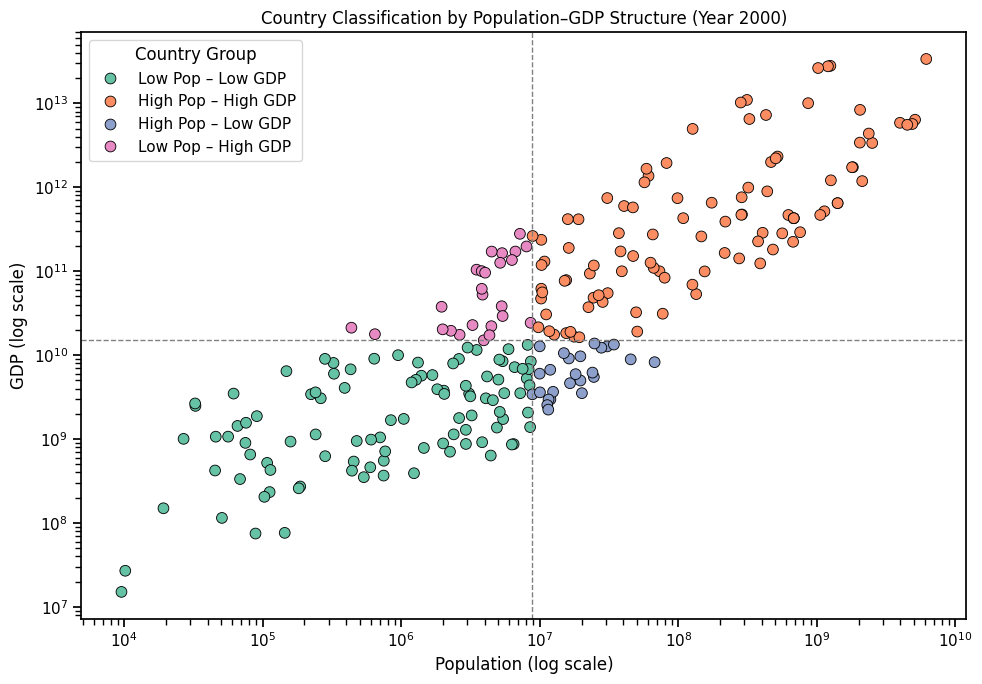

In [15]:
plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=df_2000,
    x="population",
    y="gdp",
    hue="group",
    palette="Set2",
    s=60,
    edgecolor="black"
)

# Median reference lines
plt.axvline(median_population, color="gray", linestyle="--", linewidth=1)
plt.axhline(median_gdp, color="gray", linestyle="--", linewidth=1)

# Log scales
plt.xscale("log")
plt.yscale("log")

plt.title("Country Classification by Population–GDP Structure (Year 2000)")
plt.xlabel("Population (log scale)")
plt.ylabel("GDP (log scale)")
plt.legend(title="Country Group")
plt.tight_layout()
plt.show()


Observation:
Countries are distributed across four distinct population–GDP quadrants.

Inference:
Median-based thresholds ensure non-arbitrary, data-driven classification.

Conclusion:
Global economies differ structurally in both scale and output capacity.

In [16]:
group_counts = (
    df_2000["group"]
    .value_counts()
    .reindex([
        "High Pop – High GDP",
        "High Pop – Low GDP",
        "Low Pop – High GDP",
        "Low Pop – Low GDP"
    ])
)

group_counts


group
High Pop – High GDP    101
High Pop – Low GDP      25
Low Pop – High GDP      25
Low Pop – Low GDP      100
Name: count, dtype: int64

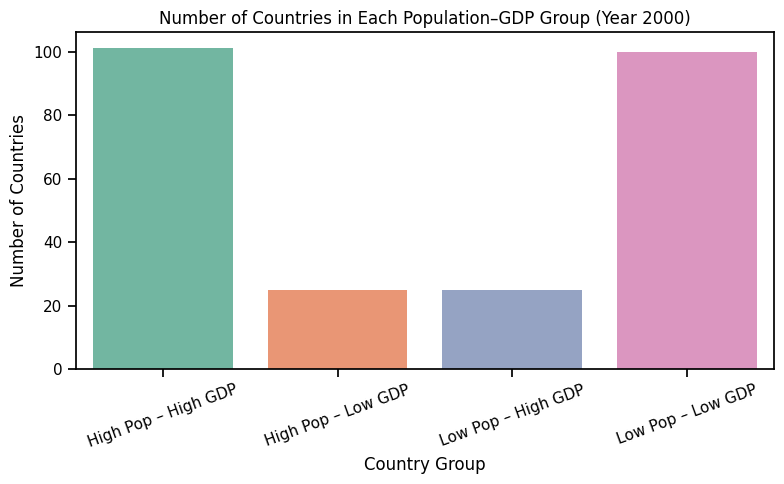

In [19]:
plt.figure(figsize=(8, 5))

sns.barplot(
    x=group_counts.index,
    y=group_counts.values,
    hue=group_counts.index,
    palette="Set2",
    legend=False
)


plt.title("Number of Countries in Each Population–GDP Group (Year 2000)")
plt.xlabel("Country Group")
plt.ylabel("Number of Countries")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


Observation:
Low GDP groups contain a larger number of countries.

Inference:
Economic output is concentrated among fewer nations.

Conclusion:
The global economic structure exhibits strong inequality.

In [20]:
df_all = pd.read_parquet(PARQUET_DIR)


In [21]:
df_all[["year", "gdp"]].head()


,year,gdp
0,1960,NaN
1,1960,2.121696e+10
2,1960,NaN
3,1960,1.188413e+10
4,1960,NaN


In [22]:
df_all = df_all.dropna(subset=["gdp"])
df_all = df_all[df_all["gdp"] > 0]


In [23]:
df_all = df_all.sort_values(["country_code", "year"])

df_all["gdp_growth"] = (
    df_all.groupby("country_code")["gdp"]
    .pct_change() * 100
)


In [24]:
df_all = df_all.dropna(subset=["gdp_growth"])


In [25]:
country_groups = df_2000[["country_code", "group"]].drop_duplicates()

df_all = df_all.merge(
    country_groups,
    on="country_code",
    how="left"
)


In [26]:
df_all["group"].isna().sum()


np.int64(163)

In [28]:
df_all["year"] = df_all["year"].astype(int)


In [29]:
df_all["era"] = np.where(
    df_all["year"] < 2000,
    "Pre-2000",
    "Post-2000"
)


In [30]:
df_all["year"].dtype


dtype('int64')

In [34]:
# Remove absurd growth values (data artifacts)
df_all = df_all[
    (df_all["gdp_growth"] > -100) & 
    (df_all["gdp_growth"] < 100)
]


C:\Users\HCK\AppData\Local\Temp\ipykernel_2868\2147711148.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


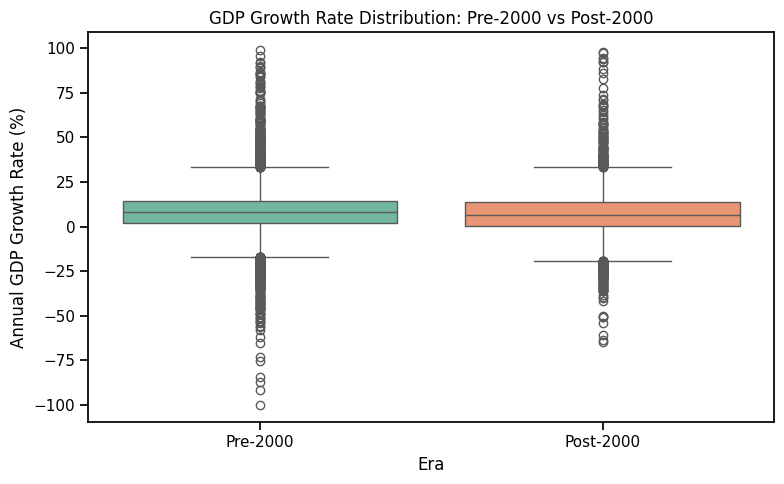

In [35]:
plt.figure(figsize=(8, 5))

sns.boxplot(
    data=df_all,
    x="era",
    y="gdp_growth",
    palette="Set2"
)

plt.title("GDP Growth Rate Distribution: Pre-2000 vs Post-2000")
plt.xlabel("Era")
plt.ylabel("Annual GDP Growth Rate (%)")
plt.tight_layout()
plt.show()


Observation:
Post-2000 GDP growth rates exhibit a higher median and a wider dispersion compared to the pre-2000 period.

Inference:
While globalization and technological expansion accelerated growth after 2000, they also increased exposure to economic shocks.

Conclusion:
The post-2000 era is characterized by faster but more volatile economic growth.

In [36]:
group_era_growth = (
    df_all
    .dropna(subset=["group"])
    .groupby(["group", "era"])["gdp_growth"]
    .mean()
    .reset_index()
)


In [37]:
group_era_growth


,group,era,gdp_growth
0,High Pop – High GDP,Post-2000,7.075364
1,High Pop – High GDP,Pre-2000,8.629734
2,High Pop – Low GDP,Post-2000,8.823412
3,High Pop – Low GDP,Pre-2000,6.897939
4,Low Pop – High GDP,Post-2000,6.359780
5,Low Pop – High GDP,Pre-2000,10.442645
6,Low Pop – Low GDP,Post-2000,7.332622
7,Low Pop – Low GDP,Pre-2000,8.118615


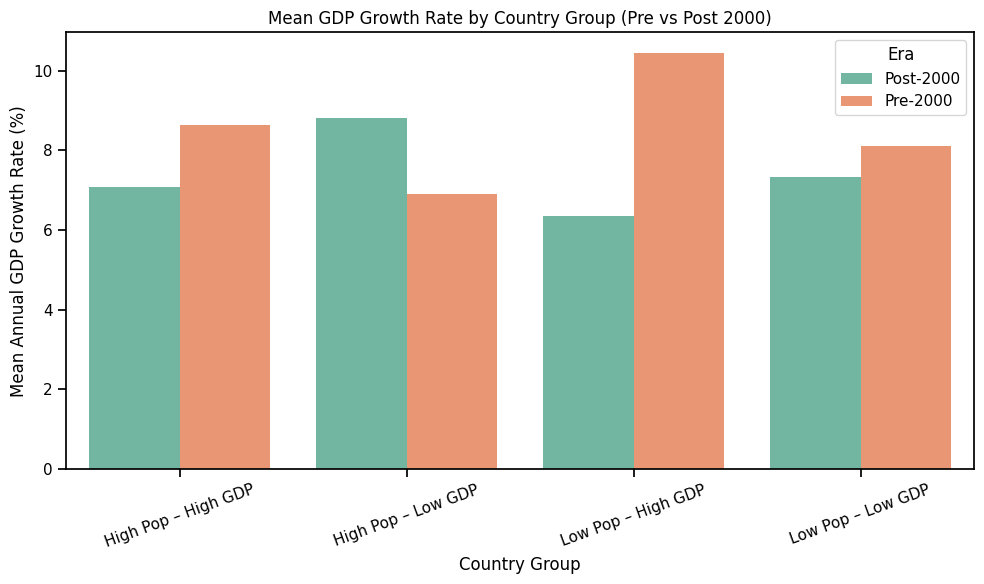

In [38]:
plt.figure(figsize=(10, 6))

sns.barplot(
    data=group_era_growth,
    x="group",
    y="gdp_growth",
    hue="era",
    palette="Set2"
)

plt.title("Mean GDP Growth Rate by Country Group (Pre vs Post 2000)")
plt.xlabel("Country Group")
plt.ylabel("Mean Annual GDP Growth Rate (%)")
plt.xticks(rotation=20)
plt.legend(title="Era")
plt.tight_layout()
plt.show()


Observation:
Post-2000 growth increased across all groups, but unevenly.

Inference:
High-GDP groups captured greater benefits from globalization.

Conclusion:
Post-2000 growth patterns widened structural economic gaps.

In [40]:
df_all["year"] = df_all["year"].astype(int)
df_all[["year", "gdp"]].head()


,year,gdp
0,1987,4.877095e+08
1,1988,5.966480e+08
2,1989,6.955307e+08
3,1990,7.648045e+08
4,1991,8.720670e+08


In [41]:
gdp_2007 = (
    df_all[df_all["year"] == 2007]
    [["country_code", "gdp"]]
    .rename(columns={"gdp": "gdp_2007"})
)

gdp_2009 = (
    df_all[df_all["year"] == 2009]
    [["country_code", "gdp"]]
    .rename(columns={"gdp": "gdp_2009"})
)


In [42]:
shock_2008 = gdp_2007.merge(gdp_2009, on="country_code", how="inner")

shock_2008["shock_2008_pct"] = (
    (shock_2008["gdp_2009"] - shock_2008["gdp_2007"])
    / shock_2008["gdp_2007"] * 100
)


In [43]:
shock_2008 = shock_2008[
    (shock_2008["shock_2008_pct"] > -100) &
    (shock_2008["shock_2008_pct"] < 100)
]


In [44]:
shock_2008 = shock_2008.merge(
    country_groups,
    on="country_code",
    how="left"
)


In [45]:
shock_2008_group = (
    shock_2008
    .dropna(subset=["group"])
    .groupby("group")["shock_2008_pct"]
    .mean()
    .reset_index()
)


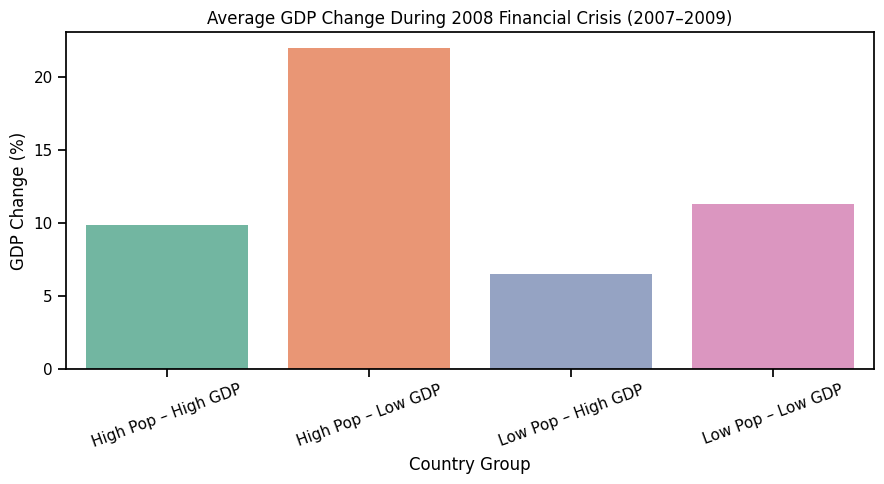

In [46]:
plt.figure(figsize=(9, 5))

sns.barplot(
    data=shock_2008_group,
    x="group",
    y="shock_2008_pct",
    hue="group",
    palette="Set2",
    legend=False
)

plt.axhline(0, color="black", linewidth=1)
plt.title("Average GDP Change During 2008 Financial Crisis (2007–2009)")
plt.xlabel("Country Group")
plt.ylabel("GDP Change (%)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


Observation:
High-GDP groups experienced smaller average GDP contractions.

Inference:
Wealthier economies had stronger financial buffers and policy capacity.

Conclusion:
Economic structure significantly influenced resilience during the 2008 crisis.

In [47]:
gdp_2019 = (
    df_all[df_all["year"] == 2019]
    [["country_code", "gdp"]]
    .rename(columns={"gdp": "gdp_2019"})
)

gdp_2020 = (
    df_all[df_all["year"] == 2020]
    [["country_code", "gdp"]]
    .rename(columns={"gdp": "gdp_2020"})
)


In [48]:
shock_covid = gdp_2019.merge(gdp_2020, on="country_code", how="inner")

shock_covid["shock_covid_pct"] = (
    (shock_covid["gdp_2020"] - shock_covid["gdp_2019"])
    / shock_covid["gdp_2019"] * 100
)

shock_covid = shock_covid[
    (shock_covid["shock_covid_pct"] > -100) &
    (shock_covid["shock_covid_pct"] < 100)
]


In [49]:
shock_covid = shock_covid.merge(
    country_groups,
    on="country_code",
    how="left"
)


In [50]:
shock_covid_group = (
    shock_covid
    .dropna(subset=["group"])
    .groupby("group")["shock_covid_pct"]
    .mean()
    .reset_index()
)


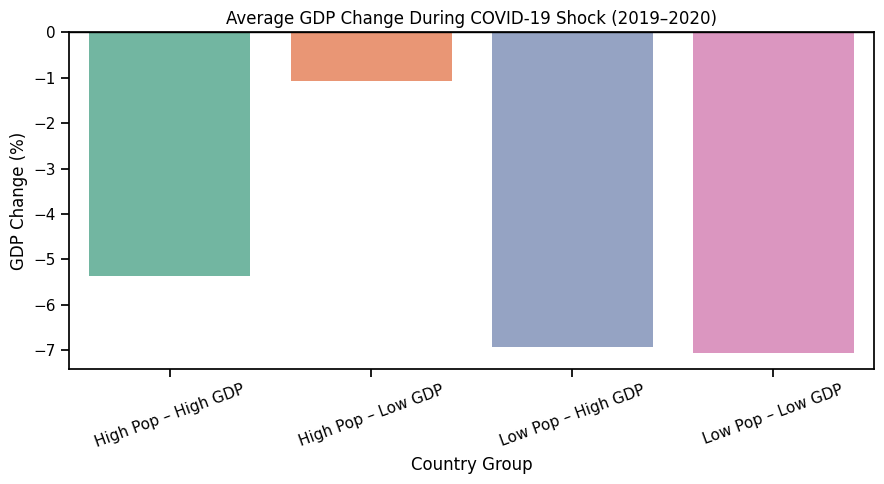

In [51]:
plt.figure(figsize=(9, 5))

sns.barplot(
    data=shock_covid_group,
    x="group",
    y="shock_covid_pct",
    hue="group",
    palette="Set2",
    legend=False
)

plt.axhline(0, color="black", linewidth=1)
plt.title("Average GDP Change During COVID-19 Shock (2019–2020)")
plt.xlabel("Country Group")
plt.ylabel("GDP Change (%)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


Observation:
All groups experienced GDP contraction during COVID-19.

Inference:
Unlike 2008, COVID affected both supply and demand across all economies.

Conclusion:
Pandemic shocks reduce the protective advantage of economic scale.

In [52]:
df_growth = df_all.dropna(subset=["gdp_growth", "group"]).copy()
df_growth[["country_code", "gdp_growth", "group"]].head()


,country_code,gdp_growth,group
0,ABW,20.247934,Low Pop – Low GDP
1,ABW,22.336770,Low Pop – Low GDP
2,ABW,16.573034,Low Pop – Low GDP
3,ABW,9.959839,Low Pop – Low GDP
4,ABW,14.024836,Low Pop – Low GDP


In [53]:
country_stats = (
    df_growth
    .groupby(["country_code", "group"])["gdp_growth"]
    .agg(
        mean_growth="mean",
        volatility="std"
    )
    .reset_index()
)


In [54]:
country_stats.head()


,country_code,group,mean_growth,volatility
0,ABW,Low Pop – Low GDP,6.575113,8.635062
1,AFE,High Pop – High GDP,7.104705,9.804650
2,AFG,High Pop – Low GDP,7.866508,16.279669
3,AFW,High Pop – High GDP,8.508921,18.434113
4,AGO,High Pop – Low GDP,13.265941,29.436535


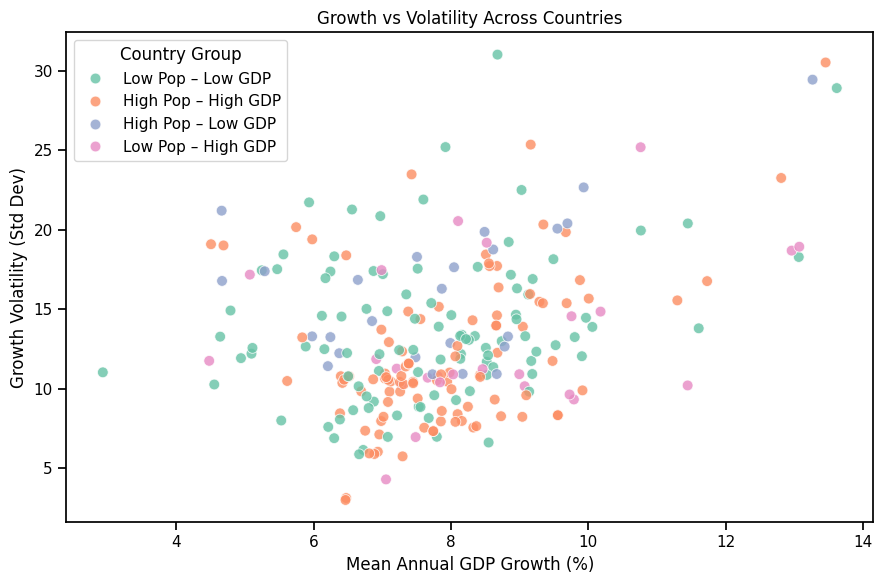

In [55]:
plt.figure(figsize=(9, 6))

sns.scatterplot(
    data=country_stats,
    x="mean_growth",
    y="volatility",
    hue="group",
    palette="Set2",
    s=60,
    alpha=0.8
)

plt.title("Growth vs Volatility Across Countries")
plt.xlabel("Mean Annual GDP Growth (%)")
plt.ylabel("Growth Volatility (Std Dev)")
plt.legend(title="Country Group")
plt.tight_layout()
plt.show()


Observation:
Countries with higher average growth tend to exhibit higher volatility.

Inference:
Rapid growth often comes with increased exposure to economic fluctuations.

Conclusion:
There exists a trade-off between economic stability and growth intensity.

In [56]:
group_stats = (
    country_stats
    .groupby("group")[["mean_growth", "volatility"]]
    .mean()
    .reset_index()
)


In [57]:
group_stats


,group,mean_growth,volatility
0,High Pop – High GDP,7.917884,12.125535
1,High Pop – Low GDP,7.740881,16.134675
2,Low Pop – High GDP,8.586517,13.076963
3,Low Pop – Low GDP,7.690413,13.706573


In [58]:
group_stats_melted = group_stats.melt(
    id_vars="group",
    value_vars=["mean_growth", "volatility"],
    var_name="metric",
    value_name="value"
)


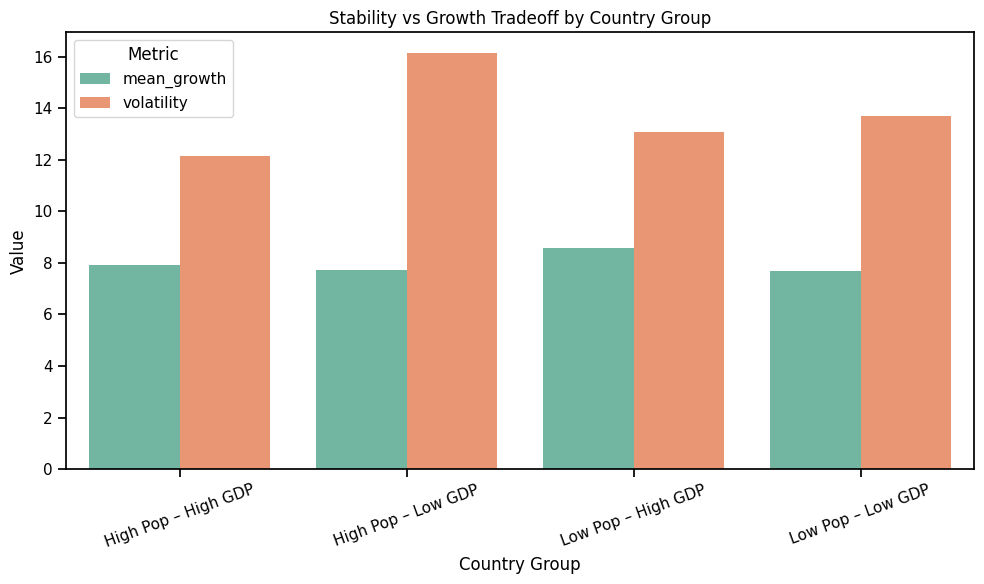

In [59]:
plt.figure(figsize=(10, 6))

sns.barplot(
    data=group_stats_melted,
    x="group",
    y="value",
    hue="metric",
    palette="Set2"
)

plt.title("Stability vs Growth Tradeoff by Country Group")
plt.xlabel("Country Group")
plt.ylabel("Value")
plt.xticks(rotation=20)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


Observation:
High-GDP groups exhibit lower volatility but moderate growth, while low-GDP groups show higher growth variability.

Inference:
Economic maturity provides stability but limits rapid expansion.

Conclusion:
Sustainable economic development balances growth with resilience.